### Sentiment Analysis of COVID-19 Vaccine Tweets
Gourav Verma & Shani Kumar<br>
DSC-680 T302, Spring 21<br>
Prof Fadi Alsaleem

In [85]:
# Import important libraries
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly as pl
import re
import datetime

import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem import LancasterStemmer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
import smart_open
smart_open.open = smart_open.smart_open
import gensim
from gensim.utils import simple_preprocess
from sklearn.model_selection import train_test_split
#import spacy
import pickle

import tensorflow as tf
import keras
from keras.utils.vis_utils import plot_model

import seaborn as sns
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

### Read COVID-19 Vaccine Tweets dataset

In [86]:
# Read the data
#raw_df = pd.read_csv("vaccination_all_tweets.csv")

raw_df = pd.read_csv("vaccine_all_en_noretweets.csv")
raw_df.head()

,index,created_at,text
0,3,Sat Oct 31 23:59:58 +0000 2020,@realDonaldTrump Trump was right again! Hydroxychloroquine treatment for Covid 19 \n💊 Dr Zelenko’s study is published in a peer reviewed journal. See it @zev_dr pinned to his profile. https://t.co/2pR44vtheE
1,10,Sun Nov 01 00:00:02 +0000 2020,@G_Shimer @BudGothmog44 Remdesivir has been sitting on shelves since ebola. It was proven in China and EU to do jack. Yet Orange bought the world supply. Same with hydroxy..the big $ is on Moderna. No track record. He has made $$$ on covid.
2,12,Sun Nov 01 00:00:04 +0000 2020,"The 'silver bullet' for coronavirus might one day cure cancer. So how does it work? https://t.co/hFYoNN2Zrw via @ABCNews Tell me, how does one create a vaccine for a virus even the CDC states has not been isolated?"
3,13,Sun Nov 01 00:00:05 +0000 2020,"@Bitflick @btcdgb @celtasia @PeterMcCormack People are fooled so badly by this ""killer virus"", lol.\nLook up the statistics. It's nearly impossible to die from this virus, yet you want to live with social distancing, masks and some rushed vaccine.\nThere is no scientific backing for the measures."
4,18,Sun Nov 01 00:00:06 +0000 2020,"Why on Earth would the American people be betting its future in a war of intrigue, advertising and deception?\nDo you want to chose a president instead of going to Russia asking for a COVID-19 vaccine?\nMr. Trump is doing it!\nThat's why it's there!\nFor free! https://t.co/5fH5l5fIkf"


In [87]:
raw_df = raw_df.drop('index', axis=1)

In [88]:
# Display some information data.
print('Dateset Shape = {}'.format(raw_df.shape))
print('Dataset Memory Usage = {:.2f} MB'.format(raw_df.memory_usage().sum() / 1024**2))
print("\n")
print(raw_df.info())

Dateset Shape = (6704661, 2)
Dataset Memory Usage = 102.31 MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6704661 entries, 0 to 6704660
Data columns (total 2 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   created_at  object
 1   text        object
dtypes: object(2)
memory usage: 102.3+ MB
None


In [89]:
# Check if there is any duplicate record
raw_df.duplicated().sum()

1818

In [90]:
raw_df.duplicated().value_counts()

False    6702843
True        1818
dtype: int64

In [91]:
# Remove dups
raw_df_unique = raw_df.drop_duplicates()
print("Shape after removing dups: ", raw_df_unique.shape)

Shape after removing dups:  (6702843, 2)


In [92]:
df_sample = raw_df_unique.sample(frac=0.20, random_state=1)

In [93]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1340569 entries, 136621 to 2592527
Data columns (total 2 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   created_at  1340569 non-null  object
 1   text        1340569 non-null  object
dtypes: object(2)
memory usage: 30.7+ MB


## Sentiment Analysis

### Read train dataset for tweets
Downloaded from: https://www.kaggle.com/c/tweet-sentiment-extraction <br>
We will use if only to train our model. Not for sentiment analysis

In [94]:
tweet_train = pd.read_csv("train.csv")

In [95]:
tweet_train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on the releases we already bought","Sons of ****,",negative


In [96]:
# Remove unnecessary columns
tweet_train = tweet_train.drop(['textID', 'text'], axis=1)
tweet_train.head()

,selected_text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD,negative
2,bullying me,negative
3,leave me alone,negative
4,"Sons of ****,",negative


In [97]:
#Check if there are any Nan values
tweet_train.isnull().sum()

selected_text    1
sentiment        0
dtype: int64

In [98]:
# remove null value record.
tweet_train = tweet_train.dropna()

In [99]:
# Print Sentniments and unique value as well
print(tweet_train.sentiment.unique())
print(tweet_train.sentiment.value_counts())

['neutral' 'negative' 'positive']
neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64


<AxesSubplot:>

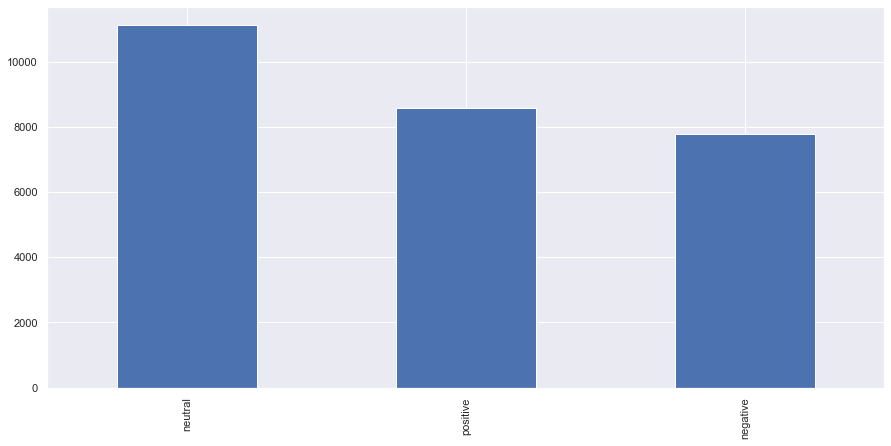

In [100]:
# Bar plot of sentiments
fig, ax = plt.subplots()
tweet_train['sentiment'].value_counts().plot(ax=ax, kind='bar')

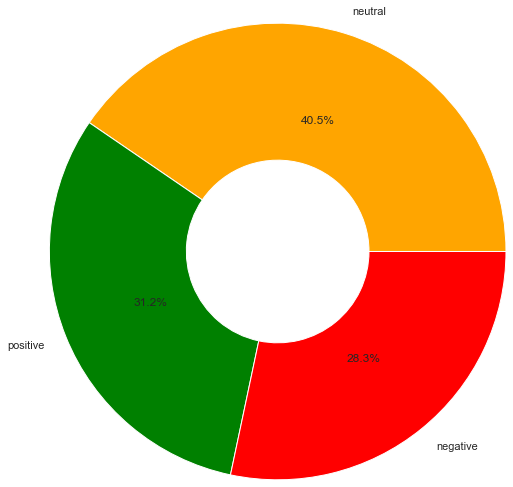

In [101]:
class_df = tweet_train.groupby('sentiment').count()['selected_text'].reset_index().sort_values(by='selected_text',ascending=False)

sentiment_pie,_,_ = plt.pie(class_df.selected_text,radius = 1.5,
                            colors=['orange', 'green', 'red'],labels=class_df.sentiment,autopct="%.1f%%")

plt.setp(sentiment_pie, width=0.9, edgecolor='white') 

plt.show()

In [102]:
tweet_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   selected_text  27480 non-null  object
 1   sentiment      27480 non-null  object
dtypes: object(2)
memory usage: 644.1+ KB


<AxesSubplot:xlabel='Hashtag', ylabel='count'>

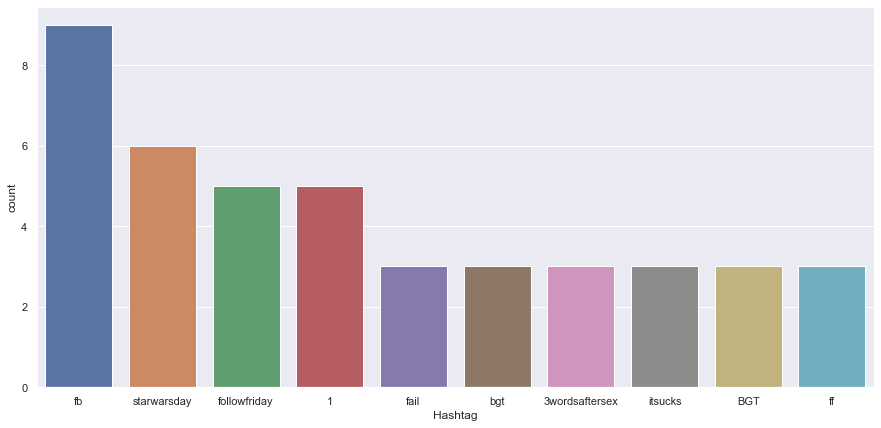

In [103]:
# check for hash tag
def get_hash(text):
    line=re.findall(r'(?<=#)\w+',text)
    return " ".join(line)

tweet_train['hash']=tweet_train['selected_text'].apply(lambda x:get_hash(x))
temp=tweet_train['hash'].value_counts()[:][1:11]
temp= temp.to_frame().reset_index().rename(columns={'index':'Hashtag','hash':'count'})

sns.set(rc={'figure.figsize':(15,7)})
sns.barplot(x="Hashtag",y="count", data = temp)

### Data Cleaning

In [107]:
#Remove stopwords & Punctuations
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))
STOPWORDS = set(stopwords.words('english'))

In [108]:
def data_cleaning(text):
    """
    Function to perform below tasks:
    - Remove URL
    - Remove emails
    - Remove newline characters
    - Remove single quotes
    """
    # Remove URLs
    url = re.compile(r'https?://\S+|www\.\S+')
    textc = url.sub(r'', text)
    
    # Remove Emails
    textc = re.sub('\S*@\S*\s?', '', textc)
    
    # Remove newline
    textc = re.sub('\s+', ' ', textc)
    
    # Remove single quotes
    textc = re.sub("\'", "", textc)
    
    # Make everything lower case
    textc = textc.lower()
    
    # remove punctuation
    textc = re.sub(r"[^\w\s\d]","", textc)
    
    # remove stopword
    textc = " ".join([word for word in str(textc).split() if word not in STOPWORDS])
    
    # remove mention
    textc=re.sub(r'@\w+','',textc)
    
    # remove hash tag
    textc=re.sub(r'#\w+','',textc)
    
    # remove extra spaces
    textc = re.sub(r"\s+"," ",textc).strip()
    

    
    return textc

In [109]:
text_list=[]

# Split selected_text to list
df_list = tweet_train['selected_text'].values.tolist()

# Clean the texts
for t in range(len(df_list)):
    text_list.append(data_cleaning(df_list[t]))

list(text_list[5:15])

['shameless plugging best rangers forum earth',
 'fun',
 'soooo high',
 '',
 'wow u became cooler',
 'much love hopeful reckon chances minimal p im never gonna get cake stuff',
 'like',
 'dangerously',
 'lost',
 'test test lg env2']

In [111]:
def data_word(sent):
    """
    Function to split sentences to words 
    """
    for s in sent:
        yield(gensim.utils.simple_preprocess(str(s), deacc=True))
    
    return

text_word = list(data_word(text_list))

print(text_word[5:15])

[['shameless', 'plugging', 'best', 'rangers', 'forum', 'earth'], ['fun'], ['soooo', 'high'], [], ['wow', 'became', 'cooler'], ['much', 'love', 'hopeful', 'reckon', 'chances', 'minimal', 'im', 'never', 'gonna', 'get', 'cake', 'stuff'], ['like'], ['dangerously'], ['lost'], ['test', 'test', 'lg', 'env']]


### Detokenization

In [112]:
def detok(text_word):
    return 

text_detok = []

for i in range(len(text_word)):
    text_detok.append(TreebankWordDetokenizer().detokenize(text_word[i]))


print(text_detok[5:15])

['shameless plugging best rangers forum earth', 'fun', 'soooo high', '', 'wow became cooler', 'much love hopeful reckon chances minimal im never gonna get cake stuff', 'like', 'dangerously', 'lost', 'test test lg env']


In [113]:
# Convert detokenized text to array
text_ar = np.array(text_detok)

### Label Encoding

In [114]:
# Convert categorical values to float

label = np.array(tweet_train['sentiment'])
num = []
for i in range(len(label)):
    if label[i] == 'neutral':
        num.append(0)
    if label[i] == 'negative':
        num.append(1)
    if label[i] == 'positive':
        num.append(2)

num = np.array(num)

label = tf.keras.utils.to_categorical(num, 3, dtype="float32")
label

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]], dtype=float32)

### Sequencing and Splitting

In [115]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint

In [116]:
max_words = 5000
max_len = 200

tokenize = Tokenizer(num_words=max_words)
tokenize.fit_on_texts(text_ar)
seq = tokenize.texts_to_sequences(text_ar)
tweet = pad_sequences(seq, maxlen=max_len)
print(tweet)

[[   0    0    0 ...    0  197   12]
 [   0    0    0 ...    0  304   27]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0  116    2]
 [   0    0    0 ...    0    0  450]
 [   0    0    0 ... 2270  116  566]]


### Model Building

In [117]:
# Split the data

X_train, X_test, y_train, y_test = train_test_split(tweet,label, random_state=0)
print (len(X_train),len(X_test),len(y_train),len(y_test))

20610 6870 20610 6870


#### Single LSTM

In [118]:
mod1 = Sequential()
mod1.add(layers.Embedding(max_words, 20))
mod1.add(layers.LSTM(15, dropout=0.5))
mod1.add(layers.Dense(3, activation='softmax'))

mod1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

ckpt1 = ModelCheckpoint('mod1.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto', 
                       period=1, save_weights_only=False)

hist = mod1.fit(X_train, y_train, epochs=1, validation_data=(X_test, y_test), callbacks=[ckpt1])

Train on 20610 samples, validate on 6870 samples
Epoch 1/1
20610/20610 [==============================] - 123s 6ms/step - loss: 0.8647 - accuracy: 0.6255 - val_loss: 0.6692 - val_accuracy: 0.7531

Epoch 00001: val_accuracy improved from -inf to 0.75313, saving model to mod1.hdf5


In [119]:
mod1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 20)          100000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 15)                2160      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 48        
Total params: 102,208
Trainable params: 102,208
Non-trainable params: 0
_________________________________________________________________


#### Bidirectional LSTM

In [120]:
mod2 = Sequential()
mod2.add(layers.Embedding(max_words, 40, input_length=max_len))
mod2.add(layers.Bidirectional(layers.LSTM(20, dropout=0.6)))
mod2.add(layers.Dense(3, activation='softmax'))
mod2.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

ckpt2 = ModelCheckpoint('mod2.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto', 
                       period=1, save_weights_only=False)

hist = mod2.fit(X_train, y_train, epochs=1, validation_data=(X_test, y_test), callbacks=[ckpt2])

Train on 20610 samples, validate on 6870 samples
Epoch 1/1
20610/20610 [==============================] - 200s 10ms/step - loss: 0.8300 - accuracy: 0.6402 - val_loss: 0.6513 - val_accuracy: 0.7453

Epoch 00001: val_accuracy improved from -inf to 0.74527, saving model to mod2.hdf5


In [121]:
mod2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 40)           200000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                9760      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 123       
Total params: 209,883
Trainable params: 209,883
Non-trainable params: 0
_________________________________________________________________


#### 1D CNN

In [122]:
mod3 = Sequential()
mod3.add(layers.Embedding(max_words, 40, input_length=max_len))
mod3.add(layers.Conv1D(20, 6, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3), 
                       bias_regularizer=regularizers.l2(2e-3)))
mod3.add(layers.MaxPooling1D(5))
mod3.add(layers.Conv1D(20, 6, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3), 
                       bias_regularizer=regularizers.l2(2e-3)))
mod3.add(layers.GlobalMaxPooling1D())
mod3.add(layers.Dense(3, activation='softmax'))
mod3.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

ckpt3 = ModelCheckpoint('mod3.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto', 
                       period=1, save_weights_only=False)

hist = mod3.fit(X_train, y_train, epochs=1, validation_data=(X_test, y_test), callbacks=[ckpt3])


Train on 20610 samples, validate on 6870 samples
Epoch 1/1
20610/20610 [==============================] - 17s 806us/step - loss: 1.0821 - acc: 0.4788 - val_loss: 0.9376 - val_acc: 0.5856


In [123]:
mod3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 40)           200000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 195, 20)           4820      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 39, 20)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 34, 20)            2420      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 63        
Total params: 207,303
Trainable params: 207,303
Non-trainable params: 0
________________________________________________

**We can see that Bidirectional RNN model showed highest accuracy. Lets validate the model.**

In [124]:
predict=mod2.predict(X_test)

<AxesSubplot:>

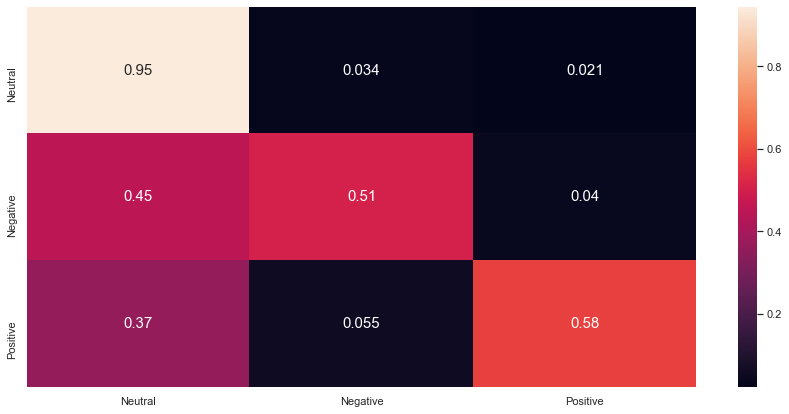

In [125]:
# Plot confusion matrix

c = confusion_matrix(y_test.argmax(axis=1), np.around(predict, decimals=0).argmax(axis=1))
matrix = pd.DataFrame(c, index=['Neutral', 'Negative', 'Positive'], columns=['Neutral', 'Negative', 'Positive'])

matrix = matrix.astype('float')/matrix.sum(axis=1)[:, np.newaxis]

sns.heatmap(matrix, annot=True, annot_kws={"size": 15})


### Sentiment analysis on COVID-19 Tweet Dataset

In [126]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1340569 entries, 136621 to 2592527
Data columns (total 2 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   created_at  1340569 non-null  object
 1   text        1340569 non-null  object
dtypes: object(2)
memory usage: 30.7+ MB


In [127]:
text_list=[]

# Split selected_text to list
df_list = df_sample['text'].values.tolist()

# Clean the texts
for t in range(len(df_list)):
    text_list.append(data_cleaning(df_list[t]))

list(text_list[5:15])

['go herd immunity stealth folk vaccinated',
 'health experts studying evidence suggesting one dose pfizers covid19 vaccine good two via',
 'university oxfords covid19 vaccine highly effective treating virus trials show',
 'ingrid virus likely still going vaccine stay home forever please',
 'ill guarantee glad scotland gb eu look proportionate share covid vaccines gb million miles ahead eu approach prime example would',
 '𝗖𝗢𝗩𝗜𝗗𝟭𝟵 𝗩𝗮𝗰𝗰𝗶𝗻𝗲 𝗜𝗻𝘃𝗶𝘁𝗮𝘁𝗶𝗼𝗻𝘀 trialling text message invitations enable patients book covid19 vaccine appointment patients smart mobile phones able book appointment via link sent text message',
 'predicted rich countries stockpile vaccine rich poorer countries secure doses power money unfortunately vaccinating small portion population wont end pandemic',
 'watch santa clara county officials provide updates coronavirus vaccine distribution jan 29 pacifica tribune via sanjosecommunity sanjose siliconvalley sanjosecommunity siliconvalleycommunity via',
 'think need replace

In [128]:
list(text_list[:10])

['vaccine wont stop covid fauci confessed vac one doesnt stop flu either',
 'winter lockdown next year nhs cant cope newer varient surprise people vaccinated getting covid',
 'wife mother received first shots covid vaccine great weight lifted didnt even realize really feels like might end one day',
 'youre scared virus youre certainly scared vaccine right',
 'johnson amp johnsons single shot covid vaccine gets us approval johnsonandjohnson vaccine coronavirus covid',
 'go herd immunity stealth folk vaccinated',
 'health experts studying evidence suggesting one dose pfizers covid19 vaccine good two via',
 'university oxfords covid19 vaccine highly effective treating virus trials show',
 'ingrid virus likely still going vaccine stay home forever please',
 'ill guarantee glad scotland gb eu look proportionate share covid vaccines gb million miles ahead eu approach prime example would']

In [129]:
text_word = list(data_word(text_list))

print(text_word[0:10])

[['vaccine', 'wont', 'stop', 'covid', 'fauci', 'confessed', 'vac', 'one', 'doesnt', 'stop', 'flu', 'either'], ['winter', 'lockdown', 'next', 'year', 'nhs', 'cant', 'cope', 'newer', 'varient', 'surprise', 'people', 'vaccinated', 'getting', 'covid'], ['wife', 'mother', 'received', 'first', 'shots', 'covid', 'vaccine', 'great', 'weight', 'lifted', 'didnt', 'even', 'realize', 'really', 'feels', 'like', 'might', 'end', 'one', 'day'], ['youre', 'scared', 'virus', 'youre', 'certainly', 'scared', 'vaccine', 'right'], ['johnson', 'amp', 'johnsons', 'single', 'shot', 'covid', 'vaccine', 'gets', 'us', 'approval', 'vaccine', 'coronavirus', 'covid'], ['go', 'herd', 'immunity', 'stealth', 'folk', 'vaccinated'], ['health', 'experts', 'studying', 'evidence', 'suggesting', 'one', 'dose', 'pfizers', 'covid', 'vaccine', 'good', 'two', 'via'], ['university', 'oxfords', 'covid', 'vaccine', 'highly', 'effective', 'treating', 'virus', 'trials', 'show'], ['ingrid', 'virus', 'likely', 'still', 'going', 'vaccin

### Detokenization

In [130]:
text_detok = []

for i in range(len(text_word)):
    text_detok.append(TreebankWordDetokenizer().detokenize(text_word[i]))


print(text_detok[0:10])

['vaccine wont stop covid fauci confessed vac one doesnt stop flu either', 'winter lockdown next year nhs cant cope newer varient surprise people vaccinated getting covid', 'wife mother received first shots covid vaccine great weight lifted didnt even realize really feels like might end one day', 'youre scared virus youre certainly scared vaccine right', 'johnson amp johnsons single shot covid vaccine gets us approval vaccine coronavirus covid', 'go herd immunity stealth folk vaccinated', 'health experts studying evidence suggesting one dose pfizers covid vaccine good two via', 'university oxfords covid vaccine highly effective treating virus trials show', 'ingrid virus likely still going vaccine stay home forever please', 'ill guarantee glad scotland gb eu look proportionate share covid vaccines gb million miles ahead eu approach prime example would']


In [131]:
# Convert detokenized text to array
text_ar = np.array(text_detok)

### Add an empty sentiment column to the dataset

In [132]:
df_sample["Sentiments"] = np.nan

In [133]:
df_sample.head(10)

,created_at,text,Sentiments
136621,Mon Nov 09 13:12:16 +0000 2020,@RepLeeZeldin The vaccine won’t stop Covid. Fauci confessed that. Vac one doesn’t stop the flu either.,NaN
4332026,Sun Feb 07 18:56:42 +0000 2021,"@scojw Winter lockdown next year - nhs can’t cope. Newer varient , surprise.... people vaccinated have been getting covid.",NaN
5872602,Wed Mar 10 18:39:54 +0000 2021,"My wife and my mother have both received their first shots of the Covid vaccine, and a great weight has lifted that I didn't even realize was there. It really feels like this might end one day now.",NaN
840839,Sat Nov 28 14:08:17 +0000 2020,"If you're not scared of the virus, you're certainly not scared of the vaccine, right? https://t.co/jWIlRUne98",NaN
5336152,Sun Feb 28 21:00:08 +0000 2021,Johnson &amp; Johnson’s single shot Covid vaccine gets US approval.\n#johnsonandjohnson #vaccine #coronavirus #covid\n\nhttps://t.co/LDl2Ta2sre https://t.co/tsQBRE5dN5,NaN
2997755,Mon Jan 11 02:34:22 +0000 2021,What about 'go for herd immunity by stealth' once folk have been vaccinated? https://t.co/h2HTnJ29qx,NaN
4846379,Thu Feb 18 19:39:37 +0000 2021,Health experts studying evidence suggesting one dose of Pfizer’s COVID-19 vaccine is as good as two /via @globeandmail 🤞https://t.co/3VsYadn92m,NaN
666338,Mon Nov 23 10:55:53 +0000 2020,"""University of Oxford's COVID-19 vaccine 'highly effective' at treating virus, trials show"" https://t.co/F81uEpbDxk",NaN
1955465,Fri Dec 18 08:56:55 +0000 2020,"@ingridmeta Ingrid, this virus is very likely still going to be here after the vaccine. Stay at home forever if you please.",NaN
2935331,Sat Jan 09 12:12:32 +0000 2021,@Chrismccloskey1 @R1989Sean @scotgov @NicolaSturgeon Ill guarantee @NicolaSturgeon is glad Scotland are in GB and not the EU when you look at the proportionate share of covid vaccines. GB is a million miles ahead of EU approach. A prime example of what would be.,NaN


In [134]:
df_sample = df_sample.reset_index(drop=True)

In [135]:
df_sample["text"].head(10)

0                                                                                                                                                                    @RepLeeZeldin The vaccine won’t stop Covid. Fauci confessed that. Vac one doesn’t stop the flu either.
1                                                                                                                                                @scojw Winter lockdown next year - nhs can’t cope. Newer varient , surprise.... people vaccinated have been getting covid.
2                                                                     My wife and my mother have both received their first shots of the Covid vaccine, and a great weight has lifted that I didn't even realize was there. It really feels like this might end one day now.
3                                                                                                                                                             If you're not scared of the virus, you

In [136]:
text_list[:10]

['vaccine wont stop covid fauci confessed vac one doesnt stop flu either',
 'winter lockdown next year nhs cant cope newer varient surprise people vaccinated getting covid',
 'wife mother received first shots covid vaccine great weight lifted didnt even realize really feels like might end one day',
 'youre scared virus youre certainly scared vaccine right',
 'johnson amp johnsons single shot covid vaccine gets us approval johnsonandjohnson vaccine coronavirus covid',
 'go herd immunity stealth folk vaccinated',
 'health experts studying evidence suggesting one dose pfizers covid19 vaccine good two via',
 'university oxfords covid19 vaccine highly effective treating virus trials show',
 'ingrid virus likely still going vaccine stay home forever please',
 'ill guarantee glad scotland gb eu look proportionate share covid vaccines gb million miles ahead eu approach prime example would']

In [137]:
len(text_list)

1340569

### Apply best model (Bidirection RNN) to the dataset

In [139]:
sentiment = ['Neutral','Negative','Positive']
for l in range(len(text_list)):
    seq = tokenize.texts_to_sequences([text_list[l]])
    tweet = pad_sequences(seq, maxlen=max_len)
    df_sample["Sentiments"][l] = sentiment[np.around(mod2.predict(tweet), decimals=0).argmax(axis=1)[0]]
    if (l % 6704 == 0):
        perc = l/len(text_list) * 100
        f_perc = "{:.0f}".format(perc)
        print(f_perc,"%")

        
final_df = df_sample
df_sample.to_csv('df_sample1.csv', index=False)

0 %
1 %
1 %
2 %
2 %
3 %
3 %
4 %
4 %
5 %
5 %


KeyboardInterrupt: 

**Applying model to dataset takes long time, So saved final dataset to a .CSV file. I will be using this CSV file for further analysis..**

In [27]:
#final_df = df_sample
#df_sample.to_csv('df_sample.csv', index=False)

In [28]:
tweet_sent = pd.read_csv('df_sample.csv')

pd.set_option('display.max_colwidth', None)
tweet_sent[["text", "Sentiments"]].head(15)

,text,Sentiments
0,Complaint against Mogoeng over COVID-19 vaccine comment escalated to JCC https://t.co/Tzo7EkpFYb via @ewnreporter,Neutral
1,"@JasonOverstreet @CNN @MSNBC @FOXNEWS - #QOP is unfit to govern! Incredibly, after 4 years of @SenateGOP ring kissing, enabling of Trump's American Carnage, silence during his deadly Covid negligence and witnessing VP Pence and Dems targeted by Trump for execution, not ONE @GOP vote for Simulus!! https://t.co/BPBT12wpbO",Neutral
2,"@thehill FDA just approved the covid vaccine too. while it's in clinical trails. lol 2021, coming soon!",Neutral
3,@JoshuaLee4rd @Plinz Covid-vaccines,Neutral
4,Nigeria’s main priority is COVID-19 vaccine – VP Osinbajo https://t.co/q3LdWuuBG7,Neutral
5,"Would love if when you went to get a Covid vaccine, someone would be there. ""Welp, looks like on October 21, you said on Facebook that it was all a hoax and the vaccine was toxic"". Back of the line. Sorry.",Neutral
6,"Petition: Prioritise teachers, school and childcare staff for Covid-19 vaccination https://t.co/imbtbl0hBd",Neutral
7,@amyyqin China kept deceiving the world &amp; its own people that the virus is not human transferrable till Jan 20 while secretly started developing vaccines on Jan 4.\nClick the below image for details. https://t.co/brGTqFsRJj,Neutral
8,"via @PerilOfAfrica #InternationalNews #Coronaviruspandemic #Health China prepares large-scale rollout of coronavirus vaccines: 2020-12-06 04:21:24 In this Sept. 24, 2020, file photo, syringes of SARS CoV-2 Vaccine for COVID-19 produced by Sinovac are… https://t.co/SumX0SicnF https://t.co/v5RrtaYhlQ",Neutral
9,Just curious why 1 of third U.S military refusing covid19 vaccine? Or is this just some rumours ?,Neutral


In [33]:
# Sentiment Counts
tweet_sent.groupby('Sentiments').nunique()

,created_at,text
Sentiments,,
Negative,3165,3142
Neutral,644539,661396
Positive,1703,1704


In [34]:
tweet_sent[tweet_sent["Sentiments"] == "Negative"].head(20)

,created_at,text,Sentiments
245,Thu Dec 24 21:51:44 +0000 2020,@CDCgov I'm not getting vaccine so..,Negative
334,Fri Mar 05 15:44:05 +0000 2021,Nigeria commences COVID-19 vaccination - https://t.co/yFa5YOrETD,Negative
477,Sun Feb 14 15:13:02 +0000 2021,Covid: Claims vaccinations harm fertility unfounded https://t.co/Wl6MYlD8tI,Negative
604,Wed Nov 18 18:04:41 +0000 2020,2k tournament https://t.co/iznyvkyNwm,Negative
744,Wed Mar 03 18:05:54 +0000 2021,Petition: Do not rollout Covid-19 vaccine passports https://t.co/HlKiBL9Bwy,Negative
859,Mon Feb 08 10:34:16 +0000 2021,Disability Partnership Calderdale newsletter 05 February 2021\n@disabilitypartnershipcalderdale @coronavirus @vaccine @consultations @usefulinfo\n#disabilitypartnershipcalderdale #coronavirus #vaccine #consultations #usefulinfo https://t.co/CwsL6AJVnz,Negative
1386,Tue Mar 09 20:38:11 +0000 2021,PHOTOS: Osun receives COVID-19 vaccine https://t.co/7hHYvNT7Kp,Negative
1474,Wed Feb 10 15:24:10 +0000 2021,Ist dose covid vaccine https://t.co/9KbcJG4TJO,Negative
1637,Thu Mar 11 10:06:42 +0000 2021,"Taraba receive 56,250 AstraZeneca COVID-19 vaccine https://t.co/LemcaKjHW1",Negative
1847,Tue Nov 17 12:42:06 +0000 2020,Trump's transition sabotage threatens vaccine rollout #SmartNews https://t.co/xmv9uPb8V1,Negative


### Taking 2nd 10% sample  ====> Ignore below code....!!!!

In [35]:
df_sample2 = raw_df.sample(frac=0.1, random_state=1)

In [36]:
df_sample2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 670466 entries, 3149017 to 4827673
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   created_at  670466 non-null  object
 1   text        670466 non-null  object
dtypes: object(2)
memory usage: 15.3+ MB


In [37]:
df_sample2["Sentiments"] = np.nan

In [38]:
df_sample2.head()

,created_at,text,Sentiments
3149017,Thu Jan 14 08:45:00 +0000 2021,Complaint against Mogoeng over COVID-19 vaccine comment escalated to JCC https://t.co/Tzo7EkpFYb via @ewnreporter,NaN
4248215,Fri Feb 05 19:04:02 +0000 2021,"@JasonOverstreet @CNN @MSNBC @FOXNEWS - #QOP is unfit to govern! Incredibly, after 4 years of @SenateGOP ring kissing, enabling of Trump's American Carnage, silence during his deadly Covid negligence and witnessing VP Pence and Dems targeted by Trump for execution, not ONE @GOP vote for Simulus!! https://t.co/BPBT12wpbO",NaN
2567946,Fri Jan 01 01:23:19 +0000 2021,"@thehill FDA just approved the covid vaccine too. while it's in clinical trails. lol 2021, coming soon!",NaN
17874,Mon Nov 02 07:09:13 +0000 2020,@JoshuaLee4rd @Plinz Covid-vaccines,NaN
314152,Fri Nov 13 09:43:05 +0000 2020,Nigeria’s main priority is COVID-19 vaccine – VP Osinbajo https://t.co/q3LdWuuBG7,NaN


In [87]:
text_list2=[]

# Split selected_text to list
df_list2 = df_sample2['text'].values.tolist()


In [89]:
df_list2[1]

"@JasonOverstreet @CNN @MSNBC @FOXNEWS - #QOP is unfit to govern! Incredibly, after 4 years of @SenateGOP ring kissing, enabling of Trump's American Carnage, silence during his deadly Covid negligence and witnessing VP Pence and Dems targeted by Trump for execution, not ONE @GOP vote for Simulus!! https://t.co/BPBT12wpbO"

In [91]:
# Clean the texts
for t in range(len(df_list)):
    text_list2.append(data_cleaning(df_list2[t]))

list(text_list2[0:10])

['Complaint against Mogoeng over COVID-19 vaccine comment escalated to JCC via ',
 '- #QOP is unfit to govern! Incredibly, after 4 years of ring kissing, enabling of Trumps American Carnage, silence during his deadly Covid negligence and witnessing VP Pence and Dems targeted by Trump for execution, not ONE vote for Simulus!! ',
 'FDA just approved the covid vaccine too. while its in clinical trails. lol 2021, coming soon!',
 'Covid-vaccines',
 'Nigeria’s main priority is COVID-19 vaccine – VP Osinbajo ',
 'Would love if when you went to get a Covid vaccine, someone would be there. "Welp, looks like on October 21, you said on Facebook that it was all a hoax and the vaccine was toxic". Back of the line. Sorry.',
 'Petition: Prioritise teachers, school and childcare staff for Covid-19 vaccination ',
 'China kept deceiving the world &amp; its own people that the virus is not human transferrable till Jan 20 while secretly started developing vaccines on Jan 4. Click the below image for detai

In [92]:
df_sample2 = df_sample2.reset_index(drop=True)
df_sample2.head()

,created_at,text,Sentiments
0,Thu Jan 14 08:45:00 +0000 2021,Complaint against Mogoeng over COVID-19 vaccine comment escalated to JCC https://t.co/Tzo7EkpFYb via @ewnreporter,NaN
1,Fri Feb 05 19:04:02 +0000 2021,"@JasonOverstreet @CNN @MSNBC @FOXNEWS - #QOP is unfit to govern! Incredibly, after 4 years of @SenateGOP ring kissing, enabling of Trump's American Carnage, silence during his deadly Covid negligence and witnessing VP Pence and Dems targeted by Trump for execution, not ONE @GOP vote for Simulus!! https://t.co/BPBT12wpbO",NaN
2,Fri Jan 01 01:23:19 +0000 2021,"@thehill FDA just approved the covid vaccine too. while it's in clinical trails. lol 2021, coming soon!",NaN
3,Mon Nov 02 07:09:13 +0000 2020,@JoshuaLee4rd @Plinz Covid-vaccines,NaN
4,Fri Nov 13 09:43:05 +0000 2020,Nigeria’s main priority is COVID-19 vaccine – VP Osinbajo https://t.co/q3LdWuuBG7,NaN


In [93]:
len(text_list2)

670466

In [94]:
sentiment = ['Neutral','Negative','Positive']
for l in range(len(text_list2)):
    seq = tokenize.texts_to_sequences([text_list2[l]])
    tweet = pad_sequences(seq, maxlen=max_len)
    df_sample2["Sentiments"][l] = sentiment[np.around(mod2.predict(tweet), decimals=0).argmax(axis=1)[0]]
    if (l % 6704 == 0):
        perc = l/len(text_list2) * 100
        f_perc = "{:.0f}".format(perc)
        print(f_perc,"%")

        
final_df2 = df_sample2
df_sample2.to_csv('df_sample2.csv', index=False)

0 %
1 %
2 %
3 %
4 %
5 %
6 %
7 %
8 %
9 %
10 %
11 %
12 %
13 %
14 %
15 %
16 %
17 %
18 %
19 %
20 %
21 %
22 %
23 %
24 %
25 %
26 %
27 %
28 %
29 %
30 %
31 %
32 %
33 %
34 %
35 %
36 %
37 %
38 %
39 %
40 %
41 %
42 %
43 %
44 %
45 %
46 %
47 %
48 %
49 %
50 %
51 %
52 %
53 %
54 %
55 %
56 %
57 %
58 %
59 %
60 %
61 %
62 %
63 %
64 %
65 %
66 %
67 %
68 %
69 %
70 %
71 %
72 %
73 %
74 %
75 %
76 %
77 %
78 %
79 %
80 %
81 %
82 %
83 %
84 %
85 %
86 %
87 %
88 %
89 %
90 %
91 %
92 %
93 %
94 %
95 %
96 %
97 %
98 %
99 %
100 %


In [95]:
final_df2 = df_sample2
df_sample2.to_csv('df_sample2.csv', index=False)

tweet_sent2 = pd.read_csv('df_sample2.csv')

pd.set_option('display.max_colwidth', None)
tweet_sent2[["text", "Sentiments"]].head(15)

,text,Sentiments
0,Complaint against Mogoeng over COVID-19 vaccine comment escalated to JCC https://t.co/Tzo7EkpFYb via @ewnreporter,Neutral
1,"@JasonOverstreet @CNN @MSNBC @FOXNEWS - #QOP is unfit to govern! Incredibly, after 4 years of @SenateGOP ring kissing, enabling of Trump's American Carnage, silence during his deadly Covid negligence and witnessing VP Pence and Dems targeted by Trump for execution, not ONE @GOP vote for Simulus!! https://t.co/BPBT12wpbO",Neutral
2,"@thehill FDA just approved the covid vaccine too. while it's in clinical trails. lol 2021, coming soon!",Neutral
3,@JoshuaLee4rd @Plinz Covid-vaccines,Neutral
4,Nigeria’s main priority is COVID-19 vaccine – VP Osinbajo https://t.co/q3LdWuuBG7,Neutral
5,"Would love if when you went to get a Covid vaccine, someone would be there. ""Welp, looks like on October 21, you said on Facebook that it was all a hoax and the vaccine was toxic"". Back of the line. Sorry.",Neutral
6,"Petition: Prioritise teachers, school and childcare staff for Covid-19 vaccination https://t.co/imbtbl0hBd",Neutral
7,@amyyqin China kept deceiving the world &amp; its own people that the virus is not human transferrable till Jan 20 while secretly started developing vaccines on Jan 4.\nClick the below image for details. https://t.co/brGTqFsRJj,Neutral
8,"via @PerilOfAfrica #InternationalNews #Coronaviruspandemic #Health China prepares large-scale rollout of coronavirus vaccines: 2020-12-06 04:21:24 In this Sept. 24, 2020, file photo, syringes of SARS CoV-2 Vaccine for COVID-19 produced by Sinovac are… https://t.co/SumX0SicnF https://t.co/v5RrtaYhlQ",Neutral
9,Just curious why 1 of third U.S military refusing covid19 vaccine? Or is this just some rumours ?,Neutral


In [96]:
# Sentiment Counts
tweet_sent2.groupby('Sentiments').nunique()

,created_at,text
Sentiments,,
Negative,3165,3142
Neutral,644539,661396
Positive,1703,1704


In [97]:
tweet_sent2[tweet_sent2["Sentiments"] == "Negative"].head(20)

,created_at,text,Sentiments
245,Thu Dec 24 21:51:44 +0000 2020,@CDCgov I'm not getting vaccine so..,Negative
334,Fri Mar 05 15:44:05 +0000 2021,Nigeria commences COVID-19 vaccination - https://t.co/yFa5YOrETD,Negative
477,Sun Feb 14 15:13:02 +0000 2021,Covid: Claims vaccinations harm fertility unfounded https://t.co/Wl6MYlD8tI,Negative
604,Wed Nov 18 18:04:41 +0000 2020,2k tournament https://t.co/iznyvkyNwm,Negative
744,Wed Mar 03 18:05:54 +0000 2021,Petition: Do not rollout Covid-19 vaccine passports https://t.co/HlKiBL9Bwy,Negative
859,Mon Feb 08 10:34:16 +0000 2021,Disability Partnership Calderdale newsletter 05 February 2021\n@disabilitypartnershipcalderdale @coronavirus @vaccine @consultations @usefulinfo\n#disabilitypartnershipcalderdale #coronavirus #vaccine #consultations #usefulinfo https://t.co/CwsL6AJVnz,Negative
1386,Tue Mar 09 20:38:11 +0000 2021,PHOTOS: Osun receives COVID-19 vaccine https://t.co/7hHYvNT7Kp,Negative
1474,Wed Feb 10 15:24:10 +0000 2021,Ist dose covid vaccine https://t.co/9KbcJG4TJO,Negative
1637,Thu Mar 11 10:06:42 +0000 2021,"Taraba receive 56,250 AstraZeneca COVID-19 vaccine https://t.co/LemcaKjHW1",Negative
1847,Tue Nov 17 12:42:06 +0000 2020,Trump's transition sabotage threatens vaccine rollout #SmartNews https://t.co/xmv9uPb8V1,Negative


### Lets Work on Word Cloud

In [141]:
# Read the data
#raw_df = pd.read_csv("vaccination_all_tweets.csv")

sentiment_df = pd.read_csv("df_sample.csv")
sentiment_df.head()

,created_at,text,Sentiments
0,Thu Jan 14 08:45:00 +0000 2021,Complaint against Mogoeng over COVID-19 vaccine comment escalated to JCC https://t.co/Tzo7EkpFYb via @ewnreporter,Neutral
1,Fri Feb 05 19:04:02 +0000 2021,"@JasonOverstreet @CNN @MSNBC @FOXNEWS - #QOP is unfit to govern! Incredibly, after 4 years of @SenateGOP ring kissing, enabling of Trump's American Carnage, silence during his deadly Covid negligence and witnessing VP Pence and Dems targeted by Trump for execution, not ONE @GOP vote for Simulus!! https://t.co/BPBT12wpbO",Neutral
2,Fri Jan 01 01:23:19 +0000 2021,"@thehill FDA just approved the covid vaccine too. while it's in clinical trails. lol 2021, coming soon!",Neutral
3,Mon Nov 02 07:09:13 +0000 2020,@JoshuaLee4rd @Plinz Covid-vaccines,Neutral
4,Fri Nov 13 09:43:05 +0000 2020,Nigeria’s main priority is COVID-19 vaccine – VP Osinbajo https://t.co/q3LdWuuBG7,Neutral


In [142]:
#Remove Urls and HTML links
def remove_urls(text):
    url_remove = re.compile(r'https?://\S+|www\.\S+')
    return url_remove.sub(r'', text)

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

# Lower casing
def lower(text):
    low_text= text.lower()
    return low_text

# Number removal
def remove_num(text):
    remove= re.sub(r'\d+', '', text)
    return remove

def punct_remove(text):
    punct = re.sub(r"[^\w\s\d]","", text)
    return punct

def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

def remove_mention(x):
    text=re.sub(r'@\w+','',x)
    return text

def remove_hash(x):
    text=re.sub(r'#\w+','',x)
    return text

def remove_space(text):
    space_remove = re.sub(r"\s+"," ",text).strip()
    return space_remove


sentiment_df.text=sentiment_df['text'].apply(lambda x:remove_urls(x))
sentiment_df.text=sentiment_df['text'].apply(lambda x:remove_html(x))
sentiment_df.text=sentiment_df['text'].apply(lambda x:lower(x))
sentiment_df.text=sentiment_df['text'].apply(lambda x:remove_num(x))
sentiment_df.text=sentiment_df['text'].apply(lambda x:punct_remove(x))
sentiment_df.text=sentiment_df['text'].apply(lambda x:remove_stopwords(x))
sentiment_df.text=sentiment_df['text'].apply(lambda x:remove_mention(x))
sentiment_df.text=sentiment_df['text'].apply(lambda x:remove_hash(x))
sentiment_df.text=sentiment_df['text'].apply(lambda x:remove_space(x))

sentiment_df.head()

,created_at,text,Sentiments
0,Thu Jan 14 08:45:00 +0000 2021,complaint mogoeng covid vaccine comment escalated jcc via ewnreporter,Neutral
1,Fri Feb 05 19:04:02 +0000 2021,jasonoverstreet cnn msnbc foxnews qop unfit govern incredibly years senategop ring kissing enabling trumps american carnage silence deadly covid negligence witnessing vp pence dems targeted trump execution one gop vote simulus,Neutral
2,Fri Jan 01 01:23:19 +0000 2021,thehill fda approved covid vaccine clinical trails lol coming soon,Neutral
3,Mon Nov 02 07:09:13 +0000 2020,joshualeerd plinz covidvaccines,Neutral
4,Fri Nov 13 09:43:05 +0000 2020,nigerias main priority covid vaccine vp osinbajo,Neutral


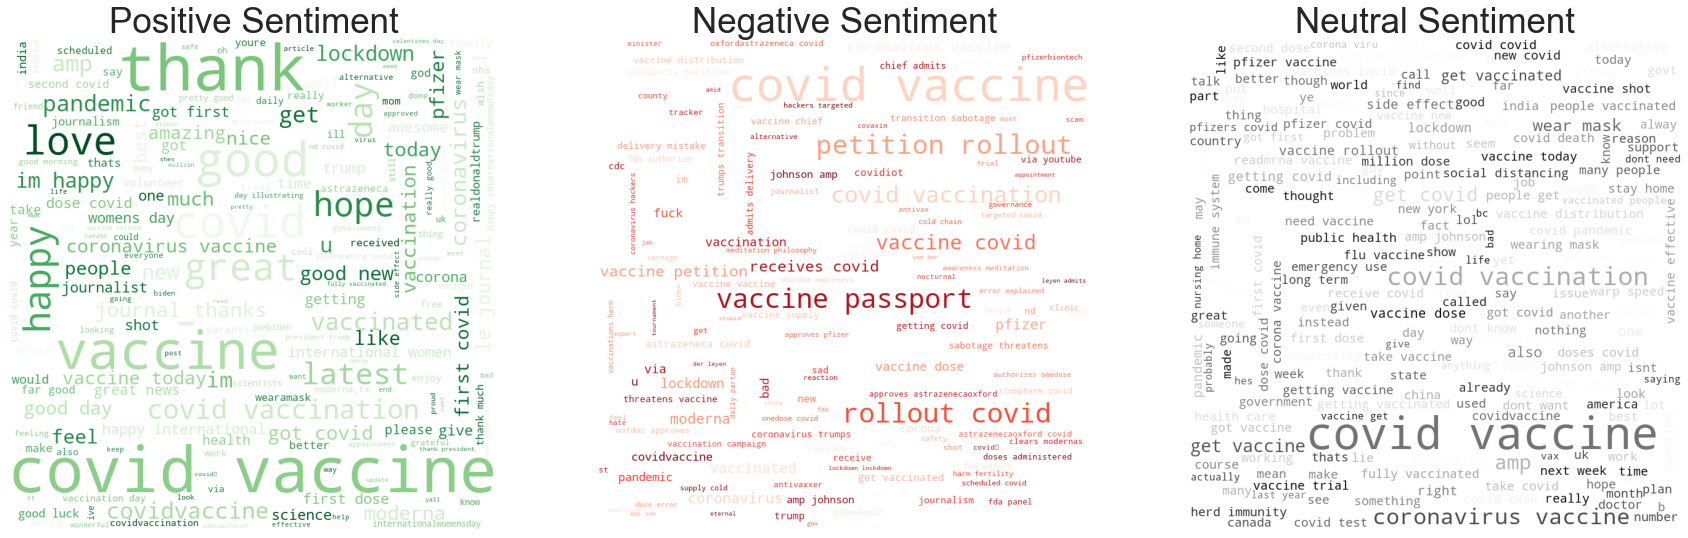

In [150]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[30, 15])

df_pos = sentiment_df[sentiment_df["Sentiments"]=="Positive"]
df_neg = sentiment_df[sentiment_df["Sentiments"]=="Negative"]
df_neu = sentiment_df[sentiment_df["Sentiments"]=="Neutral"]

comment_words = '' 
stopwords = set(STOPWORDS) 

for val in df_pos.text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
   

wordcloud1 = WordCloud(width = 800, height = 800, 
                background_color ='white',
                colormap="Greens",
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 

ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Positive Sentiment',fontsize=35);

comment_words = ''

for val in df_neg.text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "




wordcloud2 = WordCloud(width = 800, height = 800, 
                background_color ='white',
                colormap="Reds",
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words)  
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative Sentiment',fontsize=35);



comment_words = ''
for val in df_neu.text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "

wordcloud3 = WordCloud(width = 800, height = 800, 
                background_color ='white',
                colormap="Greys",
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
ax3.imshow(wordcloud3)
ax3.axis('off')
ax3.set_title('Neutral Sentiment',fontsize=35);